In [13]:
import torch

sample_path = '/root/DiT-3D/checkpoints/dit3d_raw/syn/samples_49.pth'
samples = torch.load(sample_path)
for sample in samples:
    print(sample['mid'])
    # print(sample.shape)
    # print(sample.min().item(), sample.max().item())
    # print(sample.mean().item(), sample.std().item())
    # print('---')


test/4k0u
test/2b9h
test/1ntv
test/2r7g
test/2ht9
test/4gxl
test/1ymt
test/1nq7
test/1ou8
test/2pux
test/2qos
test/2fka
test/1jbu
test/2fts
test/2ffu
test/3so6
test/4gq6
test/3w1b
test/3zqh
test/3v2x
test/1t4f
test/1uj0
test/3sfj
test/4hom
test/2xu7
test/3kuj
test/3qis
test/2qse
test/3ayu
test/1ow6
test/2vwf
test/2peh
test/1oai
test/2a3i
test/4htp
test/3vtc
test/1d4t
test/2zjd
test/1xoc
test/2w2u
test/3up3
test/2r9q
test/4j8s
test/2o02
test/3fdo
test/3ivv
test/2drk
test/3l0e
test/3bfq
test/4iim
test/1t08
test/1x2r
test/4e34
test/3awr
test/4b4n
test/2d0n
test/2p1t
test/1cvu
test/4h4f
test/3asl
test/2p54
test/1k5n
test/2fff
test/1tfc
test/3kus
test/1ssh
test/2fvj
test/4f1z
test/2oei
test/2cch
test/2o4j
test/1mfg
test/2p0w
test/2ce8
test/4ery
test/2aq9
test/2v8y
test/4dcb
test/2xvc
test/4eik
test/3olf
test/3gyt
test/2qbx
test/1oj5
test/4f14
test/3g2s
test/1nx1
test/2puy
test/1u00
test/3h1z
test/3tzy
test/1qkz
test/2o9v
test/3kmr
test/1pzl
test/1sfi
test/3obq
test/3tjv
test/3d32
test/3u9q


可视化输入的点云

Loaded 15589 peptides from /root/DiT-3D/data/peptides_only_ligand_raw/train
Loaded 133 peptides from /root/DiT-3D/data/peptides_only_ligand_raw/test


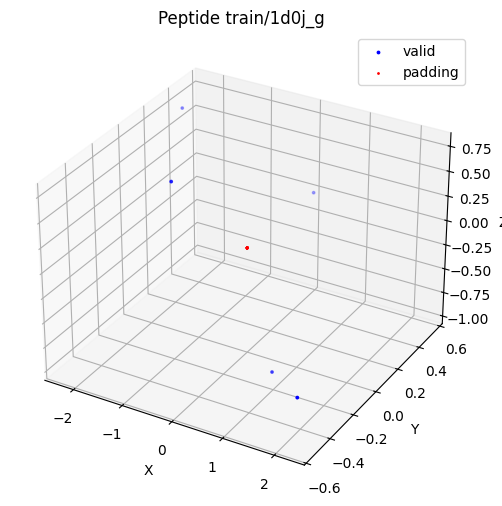

valid_points range:
min: [-2.2670672 -0.5357729 -0.9561559]
max: [2.2442193 0.5452795 0.7585773]


In [14]:
from datasets.peptide_data import PeptidePointClouds
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import torch
import numpy as np
import random

seed = 420

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 如果用 GPU，最好加：
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 让 cudnn 行为 deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



def get_dataset(dataroot, npoints, category):
    """
    获取 peptide 数据集，兼容 DiT-3D 原代码接口
    """
    tr_dataset = PeptidePointClouds(
        root_dir=dataroot,
        split='train',
        tr_sample_size=npoints,
        te_sample_size=npoints,
        scale=1.0,
        normalize_per_shape=True,
        normalize_std_per_axis=False,
        random_subsample=True
    )
    te_dataset = PeptidePointClouds(
        root_dir=dataroot,
        split='test',
        tr_sample_size=npoints,
        te_sample_size=npoints,
        scale=1.0,
        normalize_per_shape=True,
        normalize_std_per_axis=False,
        random_subsample=False,
        all_points_mean=tr_dataset.all_points_mean,
        all_points_std=tr_dataset.all_points_std
    )

    return tr_dataset, te_dataset

def get_dataloader(train_dataset, test_dataset=None):

    train_sampler = None
    test_sampler = None

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,sampler=train_sampler,
                                                   shuffle=train_sampler is None, num_workers=16, drop_last=True, collate_fn=peptide_collate_fn)

    if test_dataset is not None:
        test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,sampler=test_sampler,
                                                   shuffle=False, num_workers=16, drop_last=False, collate_fn=peptide_collate_fn)
    else:
        test_dataloader = None

    return train_dataloader, test_dataloader, train_sampler, test_sampler

def peptide_collate_fn(batch):
    out = {}

    # === train_points
    train_points_list = []
    for b in batch:
        pts = b["train_points"]
        if isinstance(pts, np.ndarray):
            pts = torch.from_numpy(pts).float()
        train_points_list.append(pts)
    train_points_padded = pad_sequence(
        train_points_list, batch_first=True, padding_value=0.0
    )
    out["train_points"] = train_points_padded

    # === test_points
    test_points_list = []
    for b in batch:
        pts = b["test_points"]
        if isinstance(pts, np.ndarray):
            pts = torch.from_numpy(pts).float()
        test_points_list.append(pts)
    test_points_padded = pad_sequence(
        test_points_list, batch_first=True, padding_value=0.0
    )
    out["test_points"] = test_points_padded

    # === lengths
    lengths = torch.tensor([x.shape[0] for x in train_points_list], dtype=torch.long)
    out["lengths"] = lengths

    # === masks
    max_len = train_points_padded.shape[1]
    mask = torch.arange(max_len)[None, :] < lengths[:, None]
    out["train_masks"] = mask
    out["test_masks"] = mask

    # === other keys
    for key in batch[0].keys():
        if key in ["train_points", "test_points"]:
            continue

        values = [b[key] for b in batch]

        if isinstance(values[0], np.ndarray):
            out[key] = torch.stack([torch.from_numpy(v).float() for v in values])
        elif isinstance(values[0], torch.Tensor):
            out[key] = torch.stack(values)
        elif isinstance(values[0], (int, float)):
            out[key] = torch.tensor(values)
        else:
            out[key] = values

    return out

dataroot = '/root/DiT-3D/data/peptides_only_ligand_raw'
npoints = 2048
category = 'peptide'

train_dataset, _ = get_dataset(dataroot, npoints, category)
dataloader, _, train_sampler, _ = get_dataloader(train_dataset, None)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# === 取一 batch
for batch in dataloader:
    # 我们只看第一条 peptide
    idx = 0

    # [B, L, 3]
    points = batch["train_points"][idx]          # e.g. (L, 3)
    mask = batch["train_masks"][idx]             # e.g. (L,)

    mid = batch["mid"][idx]

    # 转 numpy
    points = points.cpu().numpy()
    mask = mask.cpu().numpy()

    # 可视化
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # mask == 1 → valid points
    valid_points = points[mask == 1]
    ax.scatter(valid_points[:,0], valid_points[:,1], valid_points[:,2],
               c='b', s=3, label='valid')

    # mask == 0 → padding
    pad_points = points[mask == 0]
    if len(pad_points) > 0:
        ax.scatter(pad_points[:,0], pad_points[:,1], pad_points[:,2],
                   c='r', s=1, label='padding')

    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Peptide {mid}")
    plt.show()

    # 打印范围看看数据尺度
    print("valid_points range:")
    print("min:", valid_points.min(axis=0))
    print("max:", valid_points.max(axis=0))

    break   # 只看一 batch 就够

✅ Loaded 15722 peptides from /root/DiT-3D/data/peptides_only_ligand_label/train
✅ Loaded 133 peptides from /root/DiT-3D/data/peptides_only_ligand_label/test


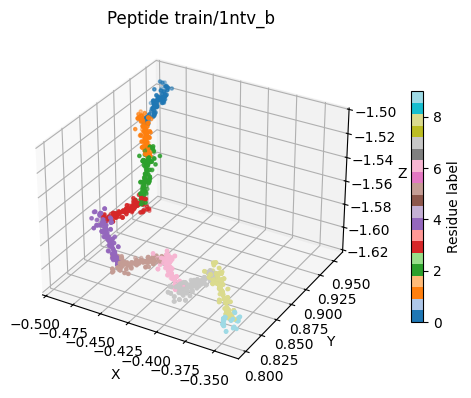

valid_points range:
min: [-0.4921185   0.79995424 -1.6141362 ]
max: [-0.34067032  0.95488757 -1.5066978 ]


In [13]:
from datasets.peptide_data_label import PeptidePointClouds
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import torch
import numpy as np
import random

seed = 10

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 如果用 GPU，最好加：
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 让 cudnn 行为 deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



def get_dataset(dataroot, npoints, category):
    """
    获取 peptide 数据集，兼容 DiT-3D 原代码接口
    """
    tr_dataset = PeptidePointClouds(
        root_dir=dataroot,
        split='train',
        tr_sample_size=npoints,
        te_sample_size=npoints,
        scale=1.0,
        normalize_per_shape=True,
        normalize_std_per_axis=False,
        random_subsample=True
    )
    te_dataset = PeptidePointClouds(
        root_dir=dataroot,
        split='test',
        tr_sample_size=npoints,
        te_sample_size=npoints,
        scale=1.0,
        normalize_per_shape=True,
        normalize_std_per_axis=False,
        random_subsample=False,
        # all_points_mean=tr_dataset.all_points_mean,
        # all_points_std=tr_dataset.all_points_std
    )

    return tr_dataset, te_dataset

def get_dataloader(train_dataset, test_dataset=None):

    train_sampler = None
    test_sampler = None

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1,sampler=train_sampler,
                                                   shuffle=train_sampler is None, num_workers=16, drop_last=True, collate_fn=peptide_collate_fn)

    if test_dataset is not None:
        test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1,sampler=test_sampler,
                                                   shuffle=False, num_workers=16, drop_last=False, collate_fn=peptide_collate_fn)
    else:
        test_dataloader = None

    return train_dataloader, test_dataloader, train_sampler, test_sampler


def peptide_collate_fn(batch):
    out = {}

    # === train_points
    train_points_list = [b["train_points"] for b in batch]
    train_points_padded = pad_sequence(
        train_points_list, batch_first=True, padding_value=0.0
    )
    out["train_points"] = train_points_padded

    # === test_points
    test_points_list = [b["test_points"] for b in batch]
    test_points_padded = pad_sequence(
        test_points_list, batch_first=True, padding_value=0.0
    )
    out["test_points"] = test_points_padded

    # === train_labels
    train_labels_list = [b["train_labels"] for b in batch]
    train_labels_padded = pad_sequence(
        train_labels_list, batch_first=True, padding_value=0
    )
    out["train_labels"] = train_labels_padded

    # === test_labels
    test_labels_list = [b["test_labels"] for b in batch]
    test_labels_padded = pad_sequence(
        test_labels_list, batch_first=True, padding_value=0
    )
    out["test_labels"] = test_labels_padded

    # === lengths
    lengths = torch.tensor([x.shape[0] for x in train_points_list], dtype=torch.long)
    out["lengths"] = lengths

    # === masks
    max_len = train_points_padded.shape[1]
    mask = torch.arange(max_len)[None, :] < lengths[:, None]
    out["train_masks"] = mask
    out["test_masks"] = mask

    # === other keys
    for key in batch[0].keys():
        if key in [
            "train_points",
            "test_points",
            "train_labels",
            "test_labels",
        ]:
            continue

        values = [b[key] for b in batch]

        if isinstance(values[0], np.ndarray):
            out[key] = torch.stack([torch.from_numpy(v).float() for v in values])
        elif isinstance(values[0], torch.Tensor):
            try:
                out[key] = torch.stack(values)
            except:
                out[key] = values
        elif isinstance(values[0], (int, float)):
            out[key] = torch.tensor(values)
        else:
            out[key] = values

    return out


dataroot = '/root/DiT-3D/data/peptides_only_ligand_label'
npoints = 2048
category = 'peptide'

train_dataset, _ = get_dataset(dataroot, npoints, category)
dataloader, _, train_sampler, _ = get_dataloader(train_dataset, None)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# === 取一 batch
for batch in dataloader:
    idx = 0

    points = batch["train_points"][idx]
    mask   = batch["train_masks"][idx]
    labels = batch["train_labels"][idx]
    mid    = batch["mid"][idx]

    points = points.cpu().numpy()
    mask = mask.cpu().numpy()
    labels = labels.cpu().numpy()

    valid_points = points[mask == 1]
    valid_labels = labels[mask == 1]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(valid_points[:,0],
                    valid_points[:,1],
                    valid_points[:,2],
                    c=valid_labels,
                    cmap='tab20',
                    s=5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Peptide {mid}")

    cbar = plt.colorbar(sc, ax=ax, shrink=0.5, pad=0.1)
    cbar.set_label('Residue label')

    plt.show()

    print("valid_points range:")
    print("min:", valid_points.min(axis=0))
    print("max:", valid_points.max(axis=0))

    break


Total number of data:4612
Min number of points: (train)2048 (test)2048
Total number of data:662
Min number of points: (train)2048 (test)2048


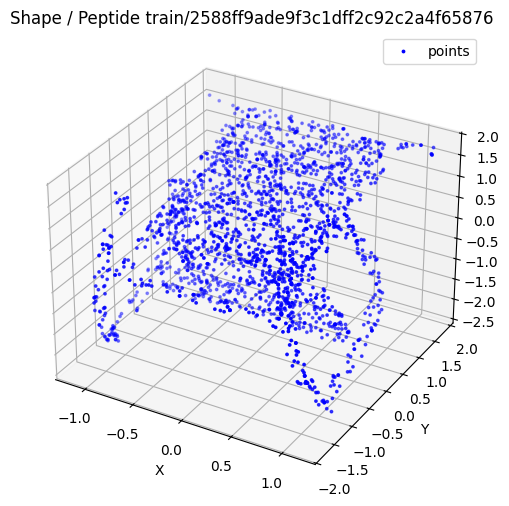

points range:
min: [-1.1450913 -1.7702031 -2.3072822]
max: [1.1563164 1.8200636 1.7369876]


In [11]:
from datasets.shapenet_data_pc import ShapeNet15kPointClouds
import numpy as np
import torch
import numpy as np
import random

seed = 420

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 如果用 GPU，最好加：
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 让 cudnn 行为 deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def get_dataset(dataroot, npoints,category):
    tr_dataset = ShapeNet15kPointClouds(root_dir=dataroot,  # 数据集存放位置
        categories=category.split(','),  # 想要训练的类别 如chair airplane
        split='train',
        tr_sample_size=npoints,  # 训练集每个样本采多少个点 （ShapeNet15kPointClouds数据集每个样本点云都是2048个点）    
        te_sample_size=npoints,  # 测试集每个样本采多少个点
        scale=1.,  # 所有点坐标放在[-1,1]之间
        normalize_per_shape=False,  # 每个点云是否单独归一化
        normalize_std_per_axis=False,  # 是否对每个轴单独归一化
        random_subsample=True)  # 是否随机采样点云中的点
    te_dataset = ShapeNet15kPointClouds(root_dir=dataroot,
        categories=category.split(','), split='val',
        tr_sample_size=npoints,
        te_sample_size=npoints,
        scale=1.,
        normalize_per_shape=False,
        normalize_std_per_axis=False,
        all_points_mean=tr_dataset.all_points_mean,
        all_points_std=tr_dataset.all_points_std,
    )
    return tr_dataset, te_dataset


def get_dataloader(train_dataset, test_dataset=None):

    
    train_sampler = None
    test_sampler = None

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,sampler=train_sampler,
                                                   shuffle=train_sampler is None, num_workers=16, drop_last=True)

    if test_dataset is not None:
        test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,sampler=test_sampler,
                                                   shuffle=False, num_workers=16, drop_last=False)
    else:
        test_dataloader = None

    return train_dataloader, test_dataloader, train_sampler, test_sampler

dataroot = '/root/DiT-3D/data/ShapeNetCore.v2.PC15k'
npoints = 2048
category = 'chair'

train_dataset, _ = get_dataset(dataroot, npoints, category)
dataloader, _, train_sampler, _ = get_dataloader(train_dataset, None)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# === 取一 batch
for batch in dataloader:
    # 我们只看第一条 shape / peptide
    idx = 0

    # [B, L, 3]
    points = batch["train_points"][idx]          # e.g. (L, 3)

    mid = batch.get("mid", None)
    if mid is not None:
        mid = mid[idx]

    mask = None

    # 转 numpy
    points = points.cpu().numpy()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 如果没有 mask，全部当 valid
    ax.scatter(points[:,0], points[:,1], points[:,2],
                c='b', s=3, label='points')

    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    title_str = f"Shape / Peptide {mid}" if mid is not None else "Shape / Peptide"
    ax.set_title(title_str)
    plt.show()

    print("points range:")
    print("min:", points.min(axis=0))
    print("max:", points.max(axis=0))

    break   # 只看一 batch 就够


label 点云 npy 读取

In [11]:
import numpy as np

path = "/root/DiT-3D/data/peptides_only_ligand_label/peptide/test/1cjr.npy"

data = np.load(path, allow_pickle=True)

print("类型：", type(data))
# 第二步：取出里面存的 dict
data_dict = data.item()

# 现在就可以用 keys()
print(data_dict.keys())
print("shape：", getattr(data, "shape", None))
print("dtype：", getattr(data, "dtype", None))
print("内容：", data)


类型： <class 'numpy.ndarray'>
dict_keys(['points', 'labels', 'center', 'scale', 'ca_coords'])
shape： ()
dtype： object
内容： {'points': array([[ 0.1260734 ,  0.94459635,  0.20315327],
       [ 0.12521875,  0.9164538 ,  0.20900184],
       [ 0.12436417,  0.88831115,  0.21485026],
       ...,
       [-0.51862496, -0.62818307, -0.18228082],
       [-0.58956957, -0.81826866, -0.03088078],
       [-0.5514473 , -0.62812364, -0.17326601]], dtype=float32), 'labels': array([ 0,  0,  0, ..., 13, 13, 13], dtype=int32), 'center': array([-15.471275,  -3.250392,  14.380795], dtype=float32), 'scale': 12.233153399932144, 'ca_coords': array([[-13.929,   8.305,  16.866],
       [-14.044,   4.518,  17.653],
       [-11.188,   2.165,  18.438],
       [ -9.676,  -0.211,  15.903],
       [-11.084,  -3.24 ,  17.574],
       [-14.568,  -1.619,  17.567],
       [-14.367,  -0.648,  13.835],
       [-13.24 ,  -4.159,  13.016],
       [-16.28 ,  -5.594,  14.786],
       [-18.656,  -3.106,  13.062],
       [-17.111,  -

In [6]:
import numpy as np

path = "/root/DiT-3D/data/peptides_only_ligand_raw/peptide/test/1cjr.npy"

data = np.load(path, allow_pickle=True)

print("类型：", type(data))
print("shape：", getattr(data, "shape", None))
print("dtype：", getattr(data, "dtype", None))
print("内容：", data)

类型： <class 'numpy.ndarray'>
shape： (15, 3)
dtype： float32
内容： [[ 0.14488654  1.          0.21114632]
 [ 0.13490853  0.6714195   0.27943075]
 [ 0.38271046  0.4672605   0.34754154]
 [ 0.51389974  0.26110598  0.12759131]
 [ 0.3917341  -0.00170639  0.27257624]
 [ 0.08944346  0.1389403   0.27196887]
 [ 0.10688332  0.22318949 -0.05183949]
 [ 0.2046679  -0.08144377 -0.12290037]
 [-0.05909896 -0.2059521   0.03067441]
 [-0.26525345  0.00992018 -0.11890911]
 [-0.13120094 -0.0522906  -0.4095732 ]
 [-0.07584458 -0.37089312 -0.40098342]
 [-0.27393004 -0.51605165 -0.17079486]
 [-0.5566116  -0.6530541  -0.23986007]
 [-0.60719585 -0.8904442  -0.02607018]]


In [8]:
import torch
import numpy as np
from Bio.PDB import PDBParser
import os

def pdb_to_ca_point_cloud(pdb_path):
    """
    从 PDB 提取所有 CA 坐标，返回 ndarray (N, 3)
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pep", pdb_path)
    coords = []
    for atom in structure.get_atoms():
        if atom.get_id() == "CA":
            coords.append(atom.get_coord())
    return np.array(coords)

def write_ca_coords_to_pdb(ca_coords, out_path, chain_id="A", start_residue=1, residue_name="GLY"):
    """
    将 CA 坐标写出为 PDB 文件
    """
    with open(out_path, "w") as f:
        for i, coord in enumerate(ca_coords, start=start_residue):
            x, y, z = coord
            record = (
                f"ATOM  {i:5d}  CA  {residue_name:<3s} {chain_id}{i:4d}    "
                f"{x:8.3f}{y:8.3f}{z:8.3f}  1.00  1.00           C\n"
            )
            f.write(record)
        f.write("END\n")
    print(f"✅ Wrote PDB to {out_path}")

def compute_rmsd(pred, gt):
    """
    计算 RMSD
    """
    if len(pred) != len(gt):
        raise ValueError(f"长度不一致: pred={len(pred)} vs gt={len(gt)}")
    diff = pred - gt
    rmsd = np.sqrt(np.mean(np.sum(diff ** 2, axis=1)))
    return rmsd

# 路径配置
samples_pth_path = "/root/DiT-3D/checkpoints/dit3d_raw/syn/samples.pth"
meta_dict_path = "/root/DiT-3D/data/peptides_only_ligand_raw/peptide/meta_dict_test.npy"
raw_pdb_root = "/root/DiT-3D/data/peptide_dataset_xj/PPDbench_xj_10_repaired"

# 加载 meta_dict
meta_dict = np.load(meta_dict_path, allow_pickle=True).item()

# 加载 samples.pth
samples_list = torch.load(samples_pth_path)
print(f"✅ Loaded samples: {len(samples_list)}")

for i, item in enumerate(samples_list):

    mid = item["mid"]     # e.g. test/4k0u
    gen_coords = item["gen_coords"].numpy()    # (N, 3)

    # 提取 sample_id
    sample_id = mid.split("/")[-1]

    if sample_id not in meta_dict:
        print(f"❌ sample_id {sample_id} 不在 meta_dict 中！跳过")
        continue

    center = np.array(meta_dict[sample_id]["center"])
    scale = meta_dict[sample_id]["scale"]

    # 反归一化
    gen_coords_denorm = gen_coords * scale + center

    # 读取原始 PDB 文件
    pdb_path = os.path.join(raw_pdb_root, sample_id, "peptide_repaired.pdb")

    if not os.path.exists(pdb_path):
        print(f"❌ PDB 文件不存在: {pdb_path}")
        continue

    ca_coords_gt = pdb_to_ca_point_cloud(pdb_path)

    if ca_coords_gt.shape != gen_coords_denorm.shape:
        print(f"⚠️ CA 数量不一致: GT={ca_coords_gt.shape} vs GEN={gen_coords_denorm.shape}")
        continue

    # 计算 RMSD
    rmsd = compute_rmsd(gen_coords_denorm, ca_coords_gt)

    print(f"\n--- Sample {i} ---")
    print(f"mid: {mid}")
    print(f"center: {center}")
    print(f"scale: {scale}")
    print(f"RMSD: {rmsd:.3f} Å")

    # # 可选：写出生成的 PDB
    # pdb_out_path = f"./{sample_id}_generated.pdb"
    # write_ca_coords_to_pdb(gen_coords_denorm, pdb_out_path)


✅ Loaded samples: 133

--- Sample 0 ---
mid: test/4k0u
center: [ -3.3959341  -19.34079933   9.26806641]
scale: 9.866065979003906
RMSD: 9.071 Å

--- Sample 1 ---
mid: test/2b9h
center: [29.57024956  0.39391661 17.02433586]
scale: 11.605749130249023
RMSD: 11.607 Å

--- Sample 2 ---
mid: test/1ntv
center: [ 4.60270023 -8.52150059 16.06190109]
scale: 9.348299980163574
RMSD: 9.729 Å

--- Sample 3 ---
mid: test/2r7g
center: [ 14.5853014  -21.95379829  19.28999901]
scale: 7.329699516296387
RMSD: 7.952 Å

--- Sample 4 ---
mid: test/2ht9
center: [-24.5600872   56.7036705    0.14974999]
scale: 8.058086395263672
RMSD: 8.519 Å

--- Sample 5 ---
mid: test/4gxl
center: [-0.45618179 19.77500153 12.06072712]
scale: 6.953272819519043
RMSD: 7.884 Å

--- Sample 6 ---
mid: test/1ymt
center: [96.55319977 33.74669647 11.74679947]
scale: 7.741799354553223
RMSD: 8.524 Å

--- Sample 7 ---
mid: test/1nq7
center: [22.59289932 10.41119957 -3.398     ]
scale: 5.833898544311523
RMSD: 6.253 Å

--- Sample 8 ---
mid: 

In [5]:
import torch
from models.dit3d import DiT3D_models
from utils.visualize import visualize_pointcloud_batch
import numpy as np
from scipy.spatial import cKDTree

@torch.no_grad()
def test_geometry_roundtrip():
    # === 构建模型（不用训练） ===
    model_type = "DiT-S/4"
    model = DiT3D_models[model_type](
        input_size=16, num_classes=55, pretrained=False
    )
    model.eval().cuda()

    # === 构造一个简单的点云输入 ===
    B, N = 1, 2048
    points = torch.rand(B, 3, N).cuda() * 2 - 1   # [-1, 1]
    t = torch.zeros(B, dtype=torch.long).cuda()   # 时间步为0
    y = torch.zeros(B, dtype=torch.long).cuda()   # 类别为0
    mask = torch.ones(B, N).bool().cuda()

    # === 前向传播：点云→voxel→还原点云 ===
    out = model(points, t, y, mask)  # output shape: [B, 3, N]

    # === 评估还原精度（使用 NumPy + SciPy） ===
    def chamfer_distance_numpy(pc1, pc2):
        """
        pc1, pc2: [N, 3] numpy arrays
        Return: symmetric Chamfer Distance (mean squared)
        """
        tree1 = cKDTree(pc1)
        tree2 = cKDTree(pc2)

        dist1, _ = tree1.query(pc2)
        dist2, _ = tree2.query(pc1)

        return np.mean(dist1 ** 2) + np.mean(dist2 ** 2)

    pc_in = points[0].transpose(0, 1).cpu().numpy()   # (N, 3)
    pc_out = out[0].transpose(0, 1).cpu().numpy()     # (N, 3)

    cd = chamfer_distance_numpy(pc_in, pc_out)
    print(f"Chamfer Distance (NumPy): {cd:.6f}")

    # === 可视化 ===
    visualize_pointcloud_batch("input_points.png", points.cpu().transpose(1, 2), None, None, None)
    visualize_pointcloud_batch("output_points.png", out.cpu().transpose(1, 2), None, None, None)

    # === 保存为 PDB ===
    def save_pdb(coords, filename):
        from Bio.PDB import PDBIO, Structure, Model, Chain, Residue, Atom

        structure = Structure.Structure("pdb")
        model = Model.Model(0)
        chain = Chain.Chain("A")

        for i, c in enumerate(coords):
            # 创建一个新的残基
            res_id = (" ", i + 1, " ")  # residue id (hetero flag, seq number, insertion code)
            residue = Residue.Residue(res_id, "GLY", "")
            
            # 创建一个 CA 原子
            atom = Atom.Atom("CA", c, 1.0, 1.0, " ", "CA", i + 1, element="C")
            residue.add(atom)

            # 把残基加到链中
            chain.add(residue)

        model.add(chain)
        structure.add(model)

        io = PDBIO()
        io.set_structure(structure)
        io.save(filename)


    save_pdb(pc_in, "input.pdb")
    save_pdb(pc_out, "output.pdb")

if __name__ == '__main__':
    test_geometry_roundtrip()


grid_size: 4
Chamfer Distance (NumPy): 1.002102


In [9]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

def visualize_xyz(filepath, title='XYZ Point Cloud'):
    points = np.loadtxt(filepath)  # (N, 3)

    assert points.shape[1] == 3, "XYZ 文件格式不正确，应为三列坐标"

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
               c='blue', s=20, alpha=0.7)

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.tight_layout()
    plt.show()

# 示例调用
visualize_xyz("/root/DiT-3D/debug_test_reconstruction/test_1cka/gt.xyz")  # 替换为你的路径


<IPython.core.display.Javascript object>

单个样本 rmsd 计算和对齐后计算

In [6]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_xyz(filepath):
    """加载 .xyz 文件为 numpy 数组，shape=(N, 3)"""
    return np.loadtxt(filepath)

def normalize_to_unit_box(points):
    """
    将点云归一化到中心为0，最大范围在 [-1, 1] 内。
    实际是将所有点减中心后，按最大绝对坐标进行缩放。
    """
    center = np.mean(points, axis=0)
    shifted = points - center
    max_range = np.abs(shifted).max()
    return shifted / max_range

def compute_rmsd(A, B):
    """计算两个点云之间的 RMSD"""
    assert A.shape == B.shape
    return np.sqrt(np.mean(np.sum((A - B) ** 2, axis=1)))

def kabsch_alignment(P, Q):
    """
    使用 Kabsch 算法将 Q 对齐到 P
    P: ground truth, shape=(N,3)
    Q: predicted, shape=(N,3)
    返回对齐后的 Q
    """
    # 去质心
    P_centroid = P.mean(axis=0)
    Q_centroid = Q.mean(axis=0)
    P_centered = P - P_centroid
    Q_centered = Q - Q_centroid

    # SVD
    H = Q_centered.T @ P_centered
    U, S, Vt = np.linalg.svd(H)
    R_opt = Vt.T @ U.T

    # 修正右手系
    if np.linalg.det(R_opt) < 0:
        Vt[-1, :] *= -1
        R_opt = Vt.T @ U.T

    # 旋转 + 平移
    Q_aligned = Q_centered @ R_opt + P_centroid
    return Q_aligned

# ==== 主程序 ====

# 替换为你的文件路径
gt_path = "/root/DiT-3D/debug_test_reconstruction/test_1cjr/gt.xyz"
pred_path = "/root/DiT-3D/debug_test_reconstruction/test_1cjr/pred.xyz"

gt = load_xyz(gt_path)
pred = load_xyz(pred_path)

# 归一化
pred = normalize_to_unit_box(pred)

# 原始 RMSD
rmsd_before = compute_rmsd(gt, pred)

# 对齐 pred
pred_aligned = kabsch_alignment(gt, pred)

# 对齐后的 RMSD
rmsd_after = compute_rmsd(gt, pred_aligned)

# 打印结果
print(f"原始 RMSD: {rmsd_before:.4f}")
print(f"对齐后 RMSD: {rmsd_after:.4f}")

# ==== 可视化（可选） ====
def plot_pointclouds(gt, pred, title="Aligned Point Clouds"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(gt[:, 0], gt[:, 1], gt[:, 2], c='blue', label='GT', s=40)
    ax.scatter(pred[:, 0], pred[:, 1], pred[:, 2], c='red', label='Pred', s=40, alpha=0.6)
    ax.set_title(title)
    ax.legend()
    plt.show()

# plot_pointclouds(gt, pred, "Before Alignment")
# plot_pointclouds(gt, pred_aligned, "After Alignment")


原始 RMSD: 0.7531
对齐后 RMSD: 0.7868


文件夹下批量样本 rmsd 计算和对齐计算

In [3]:
import os
import numpy as np
import pandas as pd

def load_xyz(path):
    return np.loadtxt(path)

def kabsch_align(P, Q):
    # P, Q: (N, 3)
    P_centered = P - P.mean(0)
    Q_centered = Q - Q.mean(0)
    C = Q_centered.T @ P_centered
    V, S, Wt = np.linalg.svd(C)
    d = (np.linalg.det(V @ Wt) < 0).astype(float)
    D = np.diag([1, 1, 1 - 2 * d])
    U = V @ D @ Wt
    Q_aligned = Q_centered @ U
    return Q_aligned + P.mean(0)

def rmsd(P, Q):
    return np.sqrt(((P - Q) ** 2).sum(axis=1).mean())

def normalize_to_unit_box(points):
    """
    将点云归一化到中心为0，最大范围在 [-1, 1] 内。
    实际是将所有点减中心后，按最大绝对坐标进行缩放。
    """
    center = np.mean(points, axis=0)
    shifted = points - center
    max_range = np.abs(shifted).max()
    return shifted / max_range

# ==== 设置路径 ====
root_dir = "/root/DiT-3D/debug_test_reconstruction_notrans"  # ← 改成你自己的 xyz 根目录路径

rmsd_raw_list = []
rmsd_aligned_list = []
sample_names = []

for folder in sorted(os.listdir(root_dir)):
    folder_path = os.path.join(root_dir, folder)
    gt_path = os.path.join(folder_path, "gt.xyz")
    pred_path = os.path.join(folder_path, "pred.xyz")

    if not (os.path.exists(gt_path) and os.path.exists(pred_path)):
        continue

    gt = load_xyz(gt_path)
    
    pred = load_xyz(pred_path)
    pred = normalize_to_unit_box(pred)

    if gt.shape != pred.shape:
        print(f"⚠️ {folder}: gt {gt.shape}, pred {pred.shape} 形状不匹配，跳过")
        continue

    rmsd_raw = rmsd(gt, pred)
    pred_aligned = kabsch_align(gt, pred)
    rmsd_kabsch = rmsd(gt, pred_aligned)

    print(f"[{folder}] RMSD 原始: {rmsd_raw:.4f} | 对齐后: {rmsd_kabsch:.4f}")
    rmsd_raw_list.append(rmsd_raw)
    rmsd_aligned_list.append(rmsd_kabsch)
    sample_names.append(folder)

# ==== 汇总统计 ====
rmsd_raw_arr = np.array(rmsd_raw_list)
rmsd_aligned_arr = np.array(rmsd_aligned_list)

print("\n=== RMSD Summary ===")
print(f"样本数量: {len(rmsd_raw_arr)}")
print(f"原始 RMSD 均值: {rmsd_raw_arr.mean():.4f}")
print(f"对齐后 RMSD 均值: {rmsd_aligned_arr.mean():.4f}")
print(f"标准差: {rmsd_aligned_arr.std():.4f}")
print(f"最小值: {rmsd_aligned_arr.min():.4f}")
print(f"最大值: {rmsd_aligned_arr.max():.4f}")
print(f"中位数: {np.median(rmsd_aligned_arr):.4f}")
print(f"25%分位数: {np.percentile(rmsd_aligned_arr, 25):.4f}")
print(f"75%分位数: {np.percentile(rmsd_aligned_arr, 75):.4f}")

# # ==== 可选保存 CSV ====
# df = pd.DataFrame({
#     "Sample": sample_names,
#     "RMSD_Raw": rmsd_raw_arr,
#     "RMSD_Aligned": rmsd_aligned_arr
# })
# df.to_csv("rmsd_xyz_summary.csv", index=False)
# print("\n✅ 已保存到 rmsd_xyz_summary.csv")


[1cjr] RMSD 原始: 0.2344 | 对齐后: 0.2344
[1cka] RMSD 原始: 0.2608 | 对齐后: 0.2608
[1cvu] RMSD 原始: 0.2040 | 对齐后: 0.2040
[1d4t] RMSD 原始: 0.2018 | 对齐后: 0.2018
[1eg4] RMSD 原始: 0.2598 | 对齐后: 0.2598
[1h6w] RMSD 原始: 0.2050 | 对齐后: 0.2050
[1hc9] RMSD 原始: 0.3858 | 对齐后: 0.3858
[1jbu] RMSD 原始: 0.2192 | 对齐后: 0.2192
[1k5n] RMSD 原始: 0.1050 | 对齐后: 0.1050
fg] RMSD 原始: 0.2950 | 对齐后: 0.2950
[1nln] RMSD 原始: 0.1939 | 对齐后: 0.1939
[1nq7] RMSD 原始: 0.2407 | 对齐后: 0.2407
[1ntv] RMSD 原始: 0.2621 | 对齐后: 0.2621
[1nx1] RMSD 原始: 0.3227 | 对齐后: 0.3227
[1oai] RMSD 原始: 0.3956 | 对齐后: 0.3956
[1oj5] RMSD 原始: 0.1679 | 对齐后: 0.1679
[1ou8] RMSD 原始: 0.2341 | 对齐后: 0.2341
[1ow6] RMSD 原始: 0.1992 | 对齐后: 0.1992
[1pzl] RMSD 原始: 0.1787 | 对齐后: 0.1787
[1qkz] RMSD 原始: 0.2854 | 对齐后: 0.2854
[1rst] RMSD 原始: 0.1787 | 对齐后: 0.1787
[1rxz] RMSD 原始: 0.1974 | 对齐后: 0.1974
[1sfi] RMSD 原始: 0.2406 | 对齐后: 0.2406
[1ssh] RMSD 原始: 0.2137 | 对齐后: 0.2137
[1t08] RMSD 原始: 0.2722 | 对齐后: 0.2722
[1t4f] RMSD 原始: 0.2766 | 对齐后: 0.2766
[1t7r] RMSD 原始: 0.2856 | 对齐后: 0.2856
[1tf

检查两个 npy 文件是否一致   确定缩放 Npy 的生成逻辑

In [1]:
import numpy as np

# 加载两个文件
meta1 = np.load("/root/DiT-3D/data/peptides_only_ligand_raw_no_norm/meta_dict_test_1.npy", allow_pickle=True).item()
meta2 = np.load("/root/DiT-3D/data/peptides_only_ligand_raw/peptide/meta_dict_test.npy", allow_pickle=True).item()

# 比较 key 是否一致
keys1 = set(meta1.keys())
keys2 = set(meta2.keys())

if keys1 != keys2:
    print("❌ Key sets are different!")
    print("Only in meta1:", keys1 - keys2)
    print("Only in meta2:", keys2 - keys1)
else:
    print("✅ Key sets are identical.")

# 逐个键比较值
diff_count = 0
for key in sorted(keys1):
    v1 = meta1[key]
    v2 = meta2[key]
    for subkey in ["center", "scale"]:
        if subkey not in v1 or subkey not in v2:
            print(f"❌ {key}: missing subkey {subkey}")
            continue

        arr1 = np.array(v1[subkey])
        arr2 = np.array(v2[subkey])
        if not np.allclose(arr1, arr2, atol=1e-6):
            print(f"⚠️  {key}.{subkey} mismatch:")
            print(f"    meta1: {arr1}")
            print(f"    meta2: {arr2}")
            diff_count += 1

print(f"\n🔍 Compared {len(keys1)} entries, {diff_count} mismatches found.")


✅ Key sets are identical.

🔍 Compared 133 entries, 0 mismatches found.


读取 npy 检查点云数据范围

In [3]:
import numpy as np

npy_path = "/root/DiT-3D/data/peptides_only_ligand_raw/peptide/test/1cjr.npy"
data = np.load(npy_path, allow_pickle=True)
print("Loaded shape:", data.shape)
print("Sample data:\n", data)
print("Min:", data.min())
print("Max:", data.max())
print("Mean:", data.mean())



Loaded shape: (15, 3)
Sample data:
 [[ 0.14488654  1.          0.21114632]
 [ 0.13490853  0.6714195   0.27943075]
 [ 0.38271046  0.4672605   0.34754154]
 [ 0.51389974  0.26110598  0.12759131]
 [ 0.3917341  -0.00170639  0.27257624]
 [ 0.08944346  0.1389403   0.27196887]
 [ 0.10688332  0.22318949 -0.05183949]
 [ 0.2046679  -0.08144377 -0.12290037]
 [-0.05909896 -0.2059521   0.03067441]
 [-0.26525345  0.00992018 -0.11890911]
 [-0.13120094 -0.0522906  -0.4095732 ]
 [-0.07584458 -0.37089312 -0.40098342]
 [-0.27393004 -0.51605165 -0.17079486]
 [-0.5566116  -0.6530541  -0.23986007]
 [-0.60719585 -0.8904442  -0.02607018]]
Min: -0.8904442
Max: 1.0
Mean: -5.033281e-08
